In [2]:
    import tensorflow as tf
    from tensorflow import keras

2025-07-14 18:09:12.265538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 18:09:12.307710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:09:12.636551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:09:12.922204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752534553.185700    7265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752534553.25

In [ ]:
To do:
Implement test set
augment data
potentially try to increase complexity of data
show example of augment photos as well as non augmented
commenting
I got a lot of work to do ngl
try using as little images as possible, due to how data is loading, police cars are causing some problems with this

In [1]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Recall


2025-07-30 03:51:36.719351: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 03:51:37.157688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753865497.341171   39280 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753865497.392363   39280 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 03:51:37.801627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Was checking if path was correct need to run cell before first
print(os.path.exists(civilian_folder))  


In [34]:
#Have to use /mnt/c/ beacuse i am working through ubuntu
civilian_folder = '/mnt/c/Users/smith/Downloads/Vehicle Classification.v2i.folder/train/car'
civilian_target = 'Police_Car/data/civilian'

os.makedirs(civilian_target, exist_ok=True)

# List all images
civ_images = [f for f in os.listdir(civilian_folder) if f.lower().endswith(('.jpg', '.png'))]

# Randomly sample n images
n=50
sampled_images = random.sample(civ_images, n)

# Copy to target folder
for img_name in sampled_images:
    shutil.copy(os.path.join(civilian_folder, img_name), os.path.join(civilian_target, img_name))

In [5]:
print(f"Total police images found: {len(all_images)}")

Total police images found: 4692


In [35]:
police_folder = '/mnt/c/Users/smith/Downloads/police_cars.v1i.folder/train/Police'
police_target = 'Police_Car/data/police'

os.makedirs(police_target, exist_ok=True)

pol_images = [f for f in os.listdir(police_folder) if f.lower().endswith(('.jpg', '.png'))]
print(len(pol_images))
pn=50
sampled_pol_images = random.sample(pol_images, pn)


for img_name in sampled_pol_images:
    shutil.copy(os.path.join(police_folder, img_name), os.path.join(police_target, img_name))

260


In [36]:
data_dir = 'Police_Car/data'

# Augmentation for training only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=123
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=123
)


Found 1568 images belonging to 2 classes.
Found 391 images belonging to 2 classes.


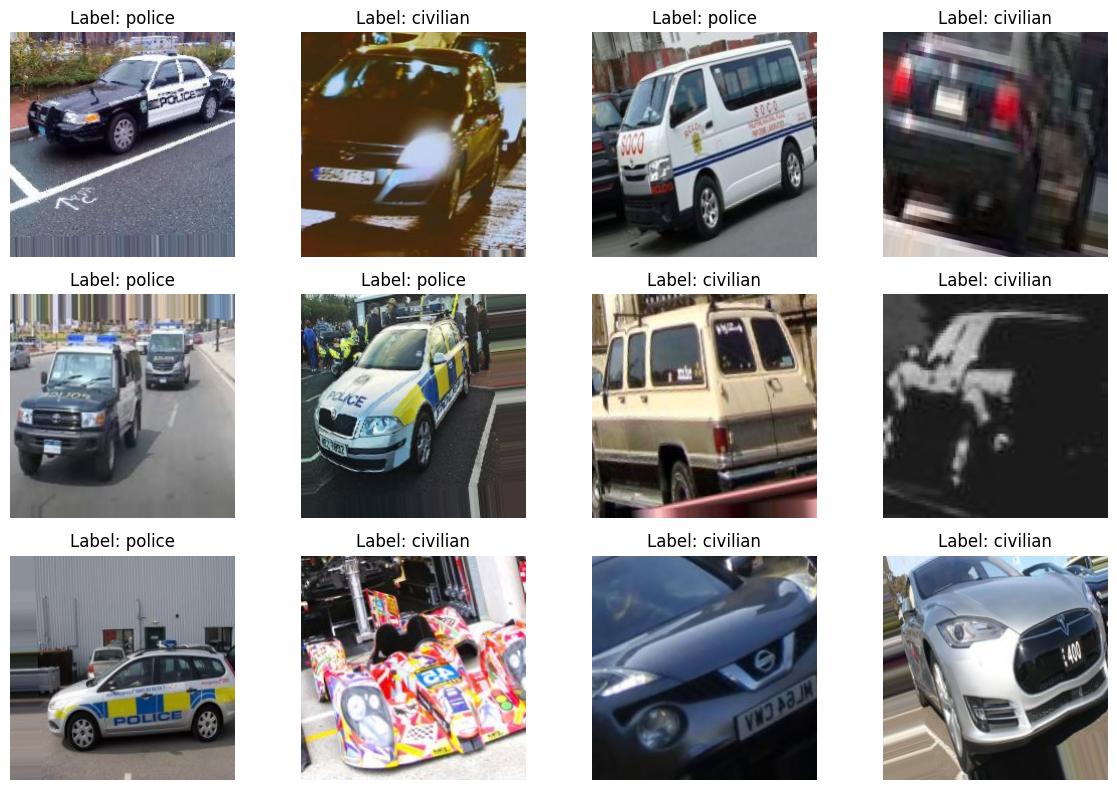

In [19]:
#looking at civilan cars

# Get class labels
class_labels = list(train_data.class_indices.keys())

images, labels = next(train_data)

plt.figure(figsize=(12, 8))

for i in range(12):
    plt.subplot(3, 4, i+1)
    img = images[i]
    label = int(labels[i])
    
    plt.imshow(img)
    plt.title(f"Label: {class_labels[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
#Using this for my model to give a proper number of steps. Prevents crashing, almost lost my file
print(f"Train generator length: {len(train_data)}")
steps_per_epoch = train_data.samples // train_data.batch_size


Train generator length: 49


In [37]:
# Was having a bit of trouble getting the class wieghts to work so I used a bit of help for the function


# Adding weights because my model was just guessing civilian everytime
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print("Class weights:", class_weights)

# funky class wieght things 
def make_class_weighted_generator(generator):
    while True:
        x, y = next(generator)
        sample_weights = np.array([class_weights[int(label)] for label in y])
        yield x, y, sample_weights

train_data_weighted = make_class_weighted_generator(train_data)

# Resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

#Im using recall here to see which class is potentially having problems
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

#early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 
history = model.fit(
    train_data_weighted,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    epochs=10,
    #callbacks=[early_stop],
    verbose=1
    
)



Class weights: {0: np.float64(0.5764705882352941), 1: np.float64(3.769230769230769)}
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5440 - loss: 0.6760 - recall_5: 0.5803

/home/smithb23/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5449 - loss: 0.6760 - recall_5: 0.5810 - val_accuracy: 0.6777 - val_loss: 0.6489 - val_recall_5: 0.7500
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6717 - loss: 0.6626 - recall_5: 0.7373 - val_accuracy: 0.6777 - val_loss: 0.6392 - val_recall_5: 0.7885
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6926 - loss: 0.6341 - recall_5: 0.7238 - val_accuracy: 0.7315 - val_loss: 0.5665 - val_recall_5: 0.6538
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7194 - loss: 0.6184 - recall_5: 0.6902 - val_accuracy: 0.7033 - val_loss: 0.5898 - val_recall_5: 0.7885
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7061 - loss: 0.5947 - recall_5: 0.6745 - val_accuracy: 0.6598 - val_loss: 0.6222 - val_recall_5: 0.8462
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7184 - loss: 0.5824 - recall_5: 0.7097 - val_accuracy: 0.5985 - val_loss: 0.6665 - val_recall_5: 0.9038
Epo

In [38]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(val_data) > 0.5).astype("int32")
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Confusion Matrix:
 [[286  53]
 [ 44   8]]


In [39]:
from sklearn.metrics import classification_report

y_pred = (model.predict(val_data) > 0.5).astype("int32")
y_true = val_data.classes

print(classification_report(y_true, y_pred, target_names=['Civilian', 'Police']))

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
              precision    recall  f1-score   support

    Civilian       0.88      0.85      0.86       339
      Police       0.18      0.21      0.19        52

    accuracy                           0.77       391
   macro avg       0.53      0.53      0.53       391
weighted avg       0.78      0.77      0.77       391



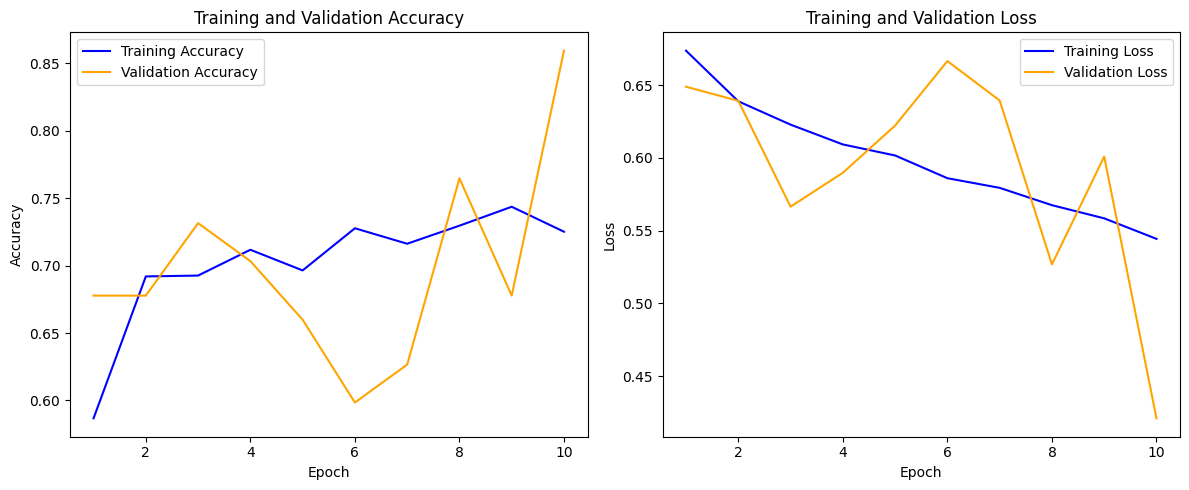

In [40]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#When using 400 civilian car images, the accuracy and validation was 100% before augmentation
#When using 1000 civilian car images, the accuracy and validation was 100% before augmentation after 1 epoch
